## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

<img src="2560px-Ride_hailing_services_Wikivoyage_banner.jpg">

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

### 1.1 Load Libraries

In [176]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

### File structure and content

In [3]:
print('We have {} rows.'.format(df.shape[0]))
print('We have {} columns'.format(df.shape[1]))
df.iloc[1,:]

We have 729322 rows.
We have 11 columns


id                              id0889885
vendor_id                               1
pickup_datetime       2016-03-11 23:35:37
dropoff_datetime      2016-03-11 23:53:57
passenger_count                         2
pickup_longitude               -73.988312
pickup_latitude                 40.731743
dropoff_longitude              -73.994751
dropoff_latitude                40.694931
store_and_fwd_flag                      N
trip_duration                        1100
Name: 1, dtype: object

At first glance, we can see the types of each variable and what they look like. 

### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [4]:
np.sum(pd.isnull(df))

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Fortunately, in this dataset we do not have any missing values which is great.

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration 

In [5]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['check_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = df[np.abs(df['check_trip_duration'].values  - df['trip_duration'].values) > 1]
duration_difference.shape

(0, 12)

This implies that there is no inconsistency in data wrt the drop location and trip duration

### Target Exploration
In this section we will take a look at the trip duration which is the target variable. It is crucial to understand it in detail as this is what we are trying to predict accurately.

In [6]:
df['trip_duration'].describe()/3600 # Trip duration in hours

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

Woah! There is a trip with duration of 538.815 hours. This is a huge outlier and might create problems at the prediction stage. One idea is to log transform the trip duration before prediction to visualise it better.

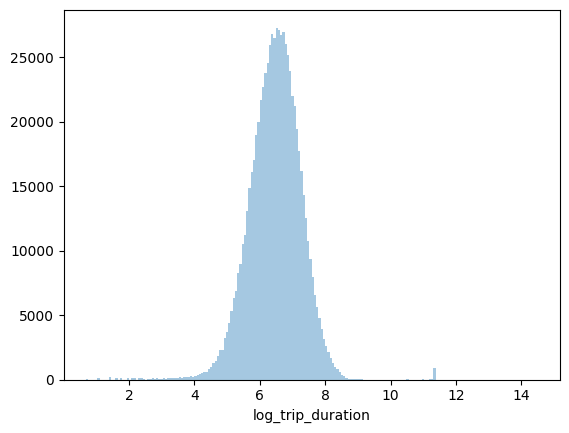

In [7]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
sns.distplot(df['log_trip_duration'], kde = False, bins = 200)
plt.show()

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 11 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.

In [8]:
from haversine import haversine
import statsmodels.formula.api as sm
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)


In [9]:
#Calculate distance and assign new column to the dataframe.
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)

In [10]:

df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration',
       'distance'],
      dtype='object')

### Univariate Visualization
First of all, let us look at some of the binary features. Looking at each feature might uncover some insight that might be useful at later modelling stages

Text(0, 0.5, 'Frequency')

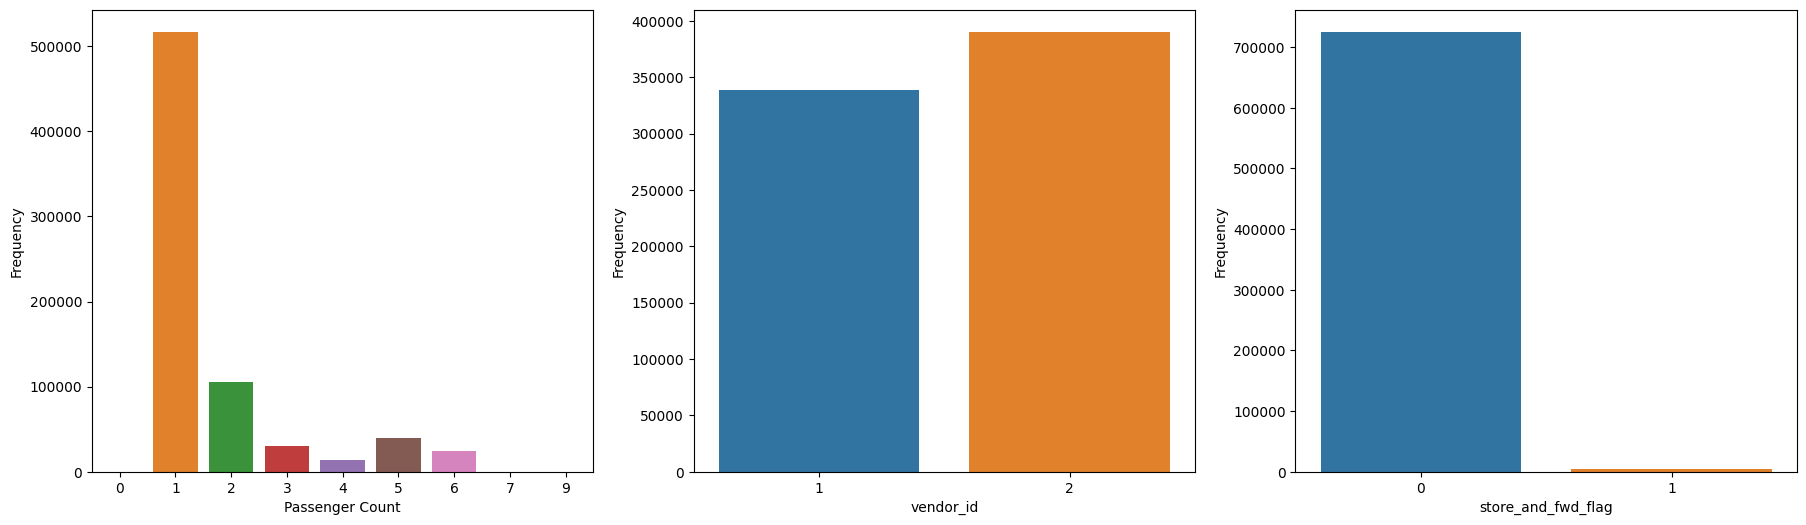

In [11]:
# Binary Features
plt.figure(figsize=(22, 6))
#fig, axs = plt.subplot(ncols=2)

# Passenger Count
plt.subplot(131)
sns.countplot(df['passenger_count'])
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')


# vendor_id
plt.subplot(132)
sns.countplot(df['vendor_id'])
plt.xlabel('vendor_id')
plt.ylabel('Frequency')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(df['store_and_fwd_flag'])
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Frequency')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1
3. The store_and_fwd_flag values, indicating whether the trip data was sent immediately to the vendor (“0”) or held in the memory of the taxi because there was no connection to the server (“1”), show that there was almost no storing taking place

Now, we will delve into the datetime features to understand the trend of number of hourly/monthly/daily taxi trips 

In [12]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

Clearly, These trips are for first 6 months of 2016. To look at trends, we first need to extract week days and hour of day from the pickup date.

In [13]:
df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['month_of_year'] = df['pickup_datetime'].dt.month

Text(0, 0.5, 'Total number of pickups')

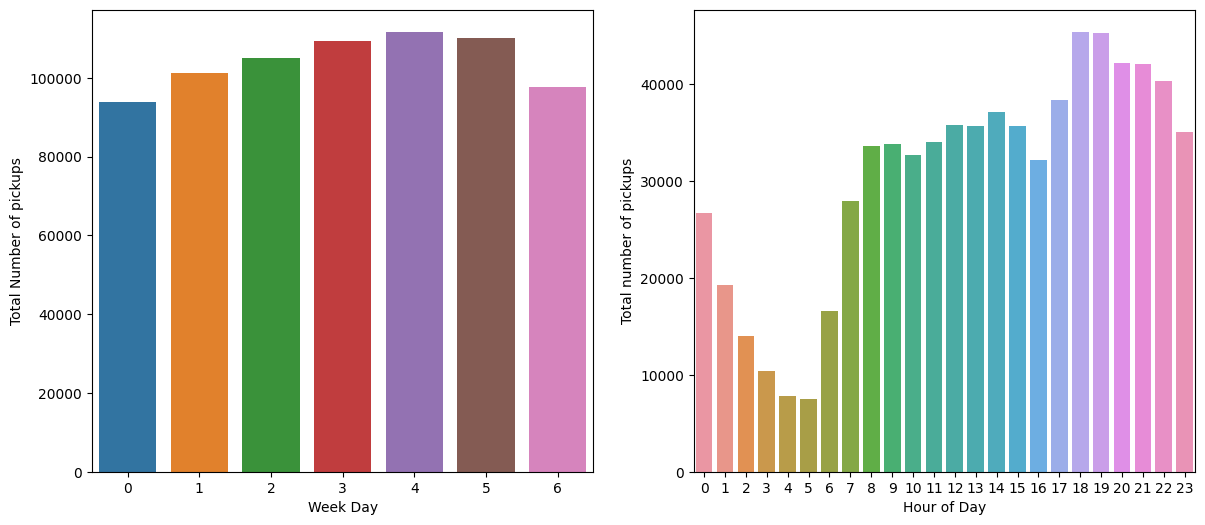

In [14]:

# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(131)
sns.countplot(df['day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')

# vendor_id
plt.subplot(132)
sns.countplot(df['hour_of_day'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')



Text(0, 0.5, 'Total number of pickups')

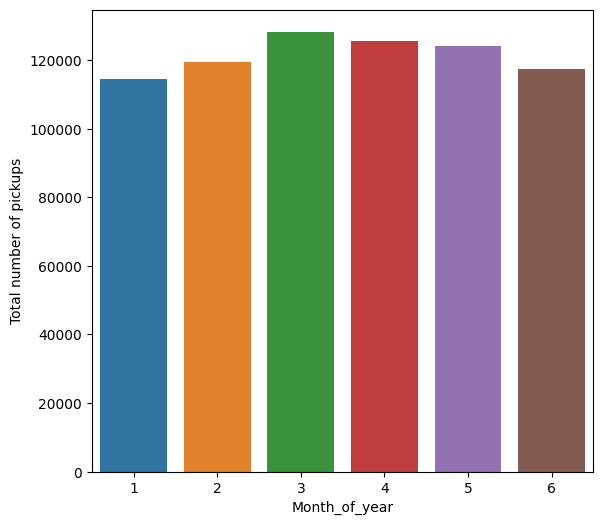

In [15]:
# Datetime features
plt.figure(figsize=(22, 6))

# Total no of pickups in the month
plt.subplot(133)
sns.countplot(df['month_of_year'])
plt.xlabel('Month_of_year')
plt.ylabel('Total number of pickups')


* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

In [16]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration', 'distance',
       'day_of_week', 'hour_of_day', 'month_of_year'],
      dtype='object')

In [17]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month,
#weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(df.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.month_of_year, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.day_of_week, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.hour_of_day, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

dummy = pd.get_dummies(df.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
df = pd.concat([df,dummy], axis = 1)

### Lattitude & Longitude

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

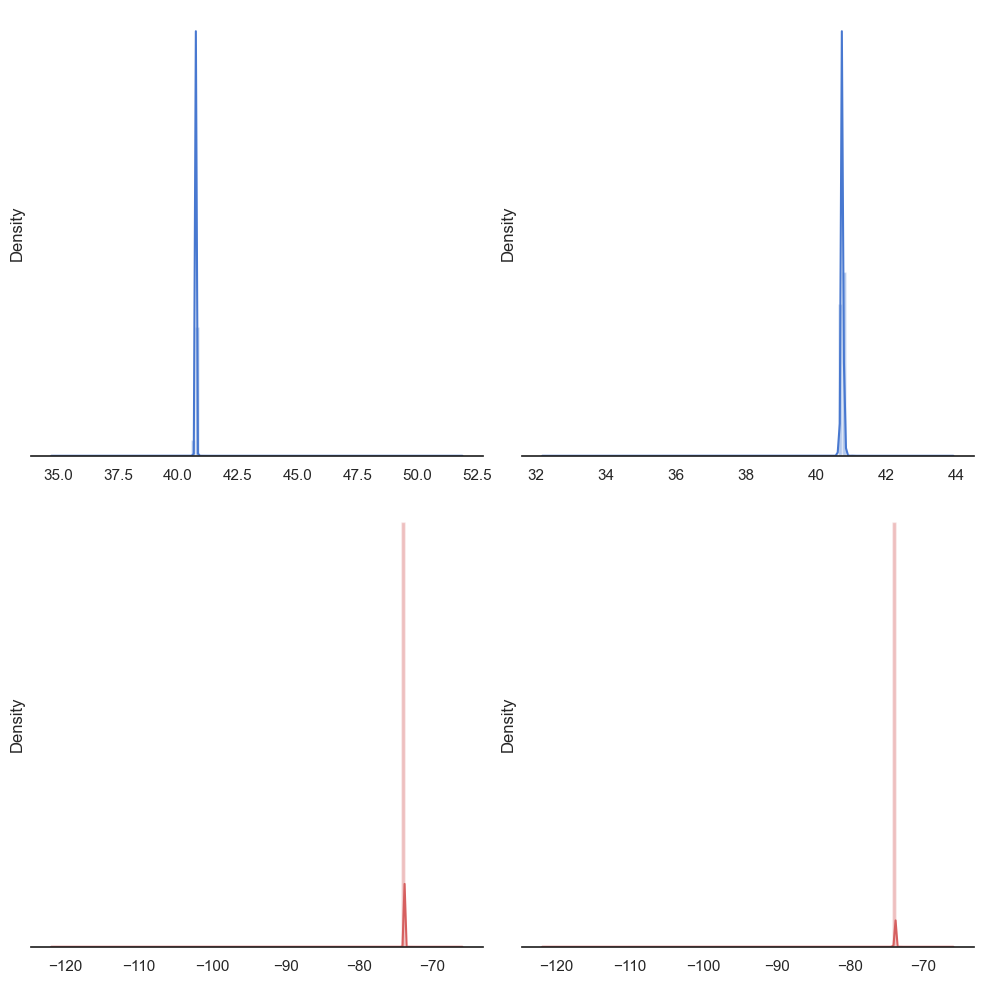

In [18]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

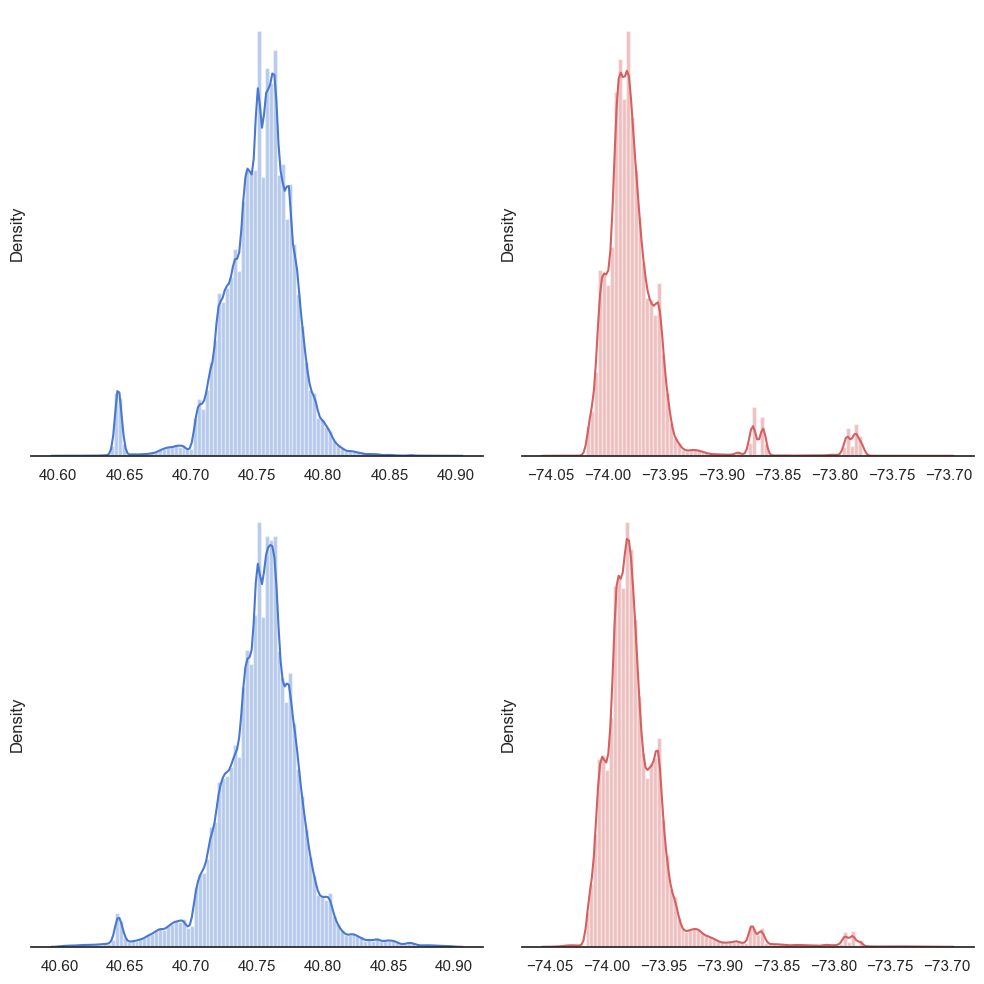

In [19]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


### Bivariate Relations with Target
Now that we have gone through all the basic features one by one. Let us start looking at their relation with the target. This will help us in selecting and extracting features at the modelling stage.

In [21]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'check_trip_duration', 'log_trip_duration', 'distance',
       'day_of_week', 'hour_of_day', 'month_of_year', 'flag_1', 'vendor_id_2',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'weekday_num_1',
       'weekday_num_2', 'weekday_num_3', 'weekday_num_4', 'weekday_num_5',
       'weekday_num_6', 'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3',
       'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7',
       'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11',
       'pickup_hour_12', 'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15',
       'pickup_hour_16', 'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19',
       'pickup_hour_20', 'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23',
       'passenger_count

### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

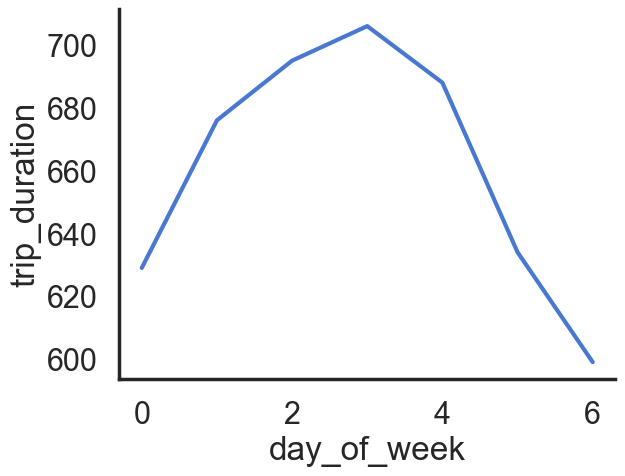

In [22]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration")
sns.despine(bottom = False)

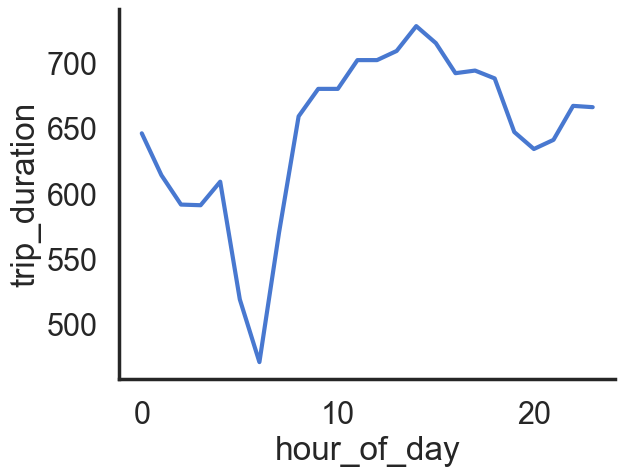

In [23]:

summary_hourly_avg_duration = pd.DataFrame(df.groupby(['hour_of_day'])['trip_duration'].median())
summary_hourly_avg_duration.reset_index(inplace = True)
summary_hourly_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", y="trip_duration")
sns.despine(bottom = False)



* Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
* It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration

### vendor_id vs Trip Duration

Let's check how the trip duration varies for different vendors.

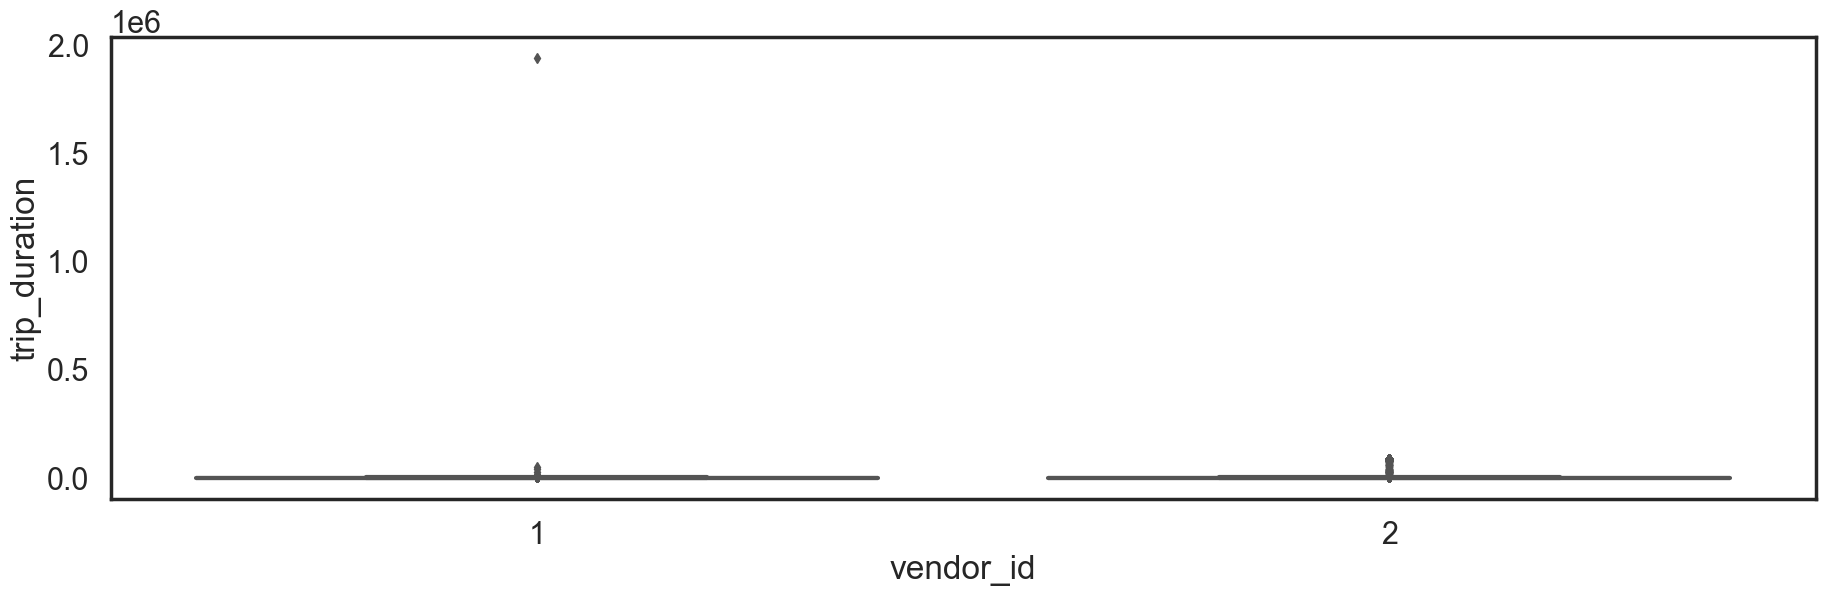

In [24]:
plt.figure(figsize=(22, 6))
sns.boxplot(x="vendor_id", y="trip_duration", data=df)
plt.show()

Woah! This did not came out as expected. The only thing I can see from this boxplot is that for vendor 2, there are a number of outliers exceeding 24 hours while vendor 1 does not have such long trips.

There could be 2 solutions to this:
1. Remove the huge outliers and plot again 
2. Look at median trip duration for both vendors on hourly basis

Let's try the first technique now and check trips below 50000 seconds only

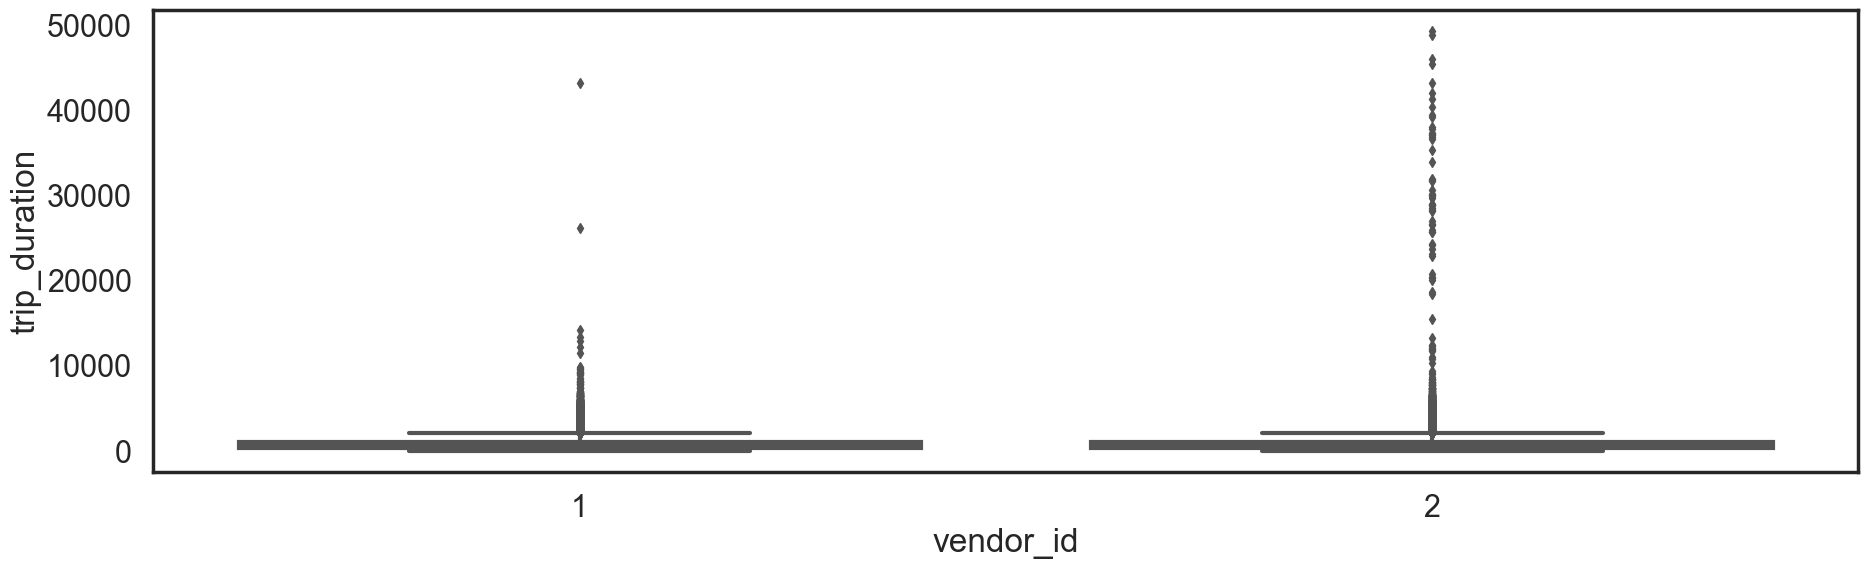

In [25]:
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=df_sub)
plt.show()

As you can see, we were in a false perception earlier that vendor 1 had more outliers. Since the median is just around 600 seconds, we observe that vendor 2 has many more outliers as compared to vendor 1. Next, to confirm this, we will quickly look at the mean wrt day of week for both vendors using tsplot (time series plot) from seaborn.

### Mean Trip Duration Vendor Wise

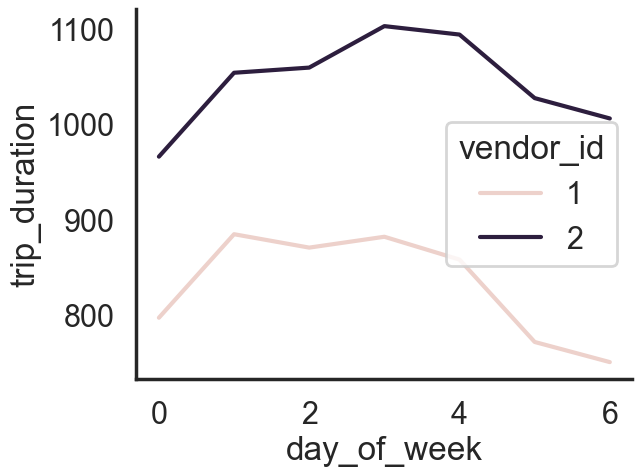

In [26]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue="vendor_id", y="trip_duration")
sns.despine(bottom = False)



### Median Trip Duration Vendor Wise

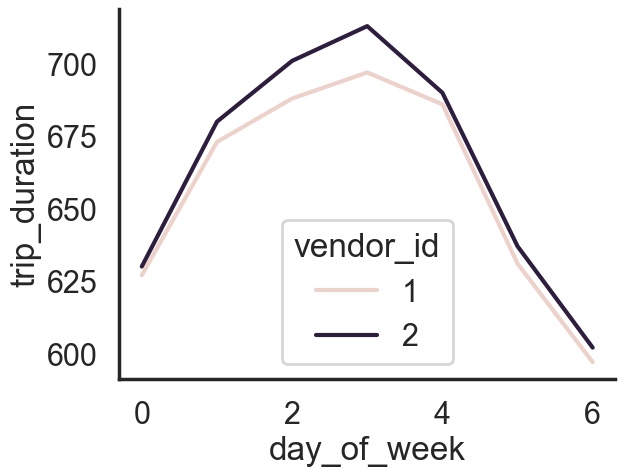

In [27]:
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['vendor_id','day_of_week'])['trip_duration'].median())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", hue="vendor_id", y="trip_duration")
sns.despine(bottom = False)



Median trip duration does not vary much as can be seen from the above plot for different vendors. It emphasises the importance of looking at the correct measure for central tendency for analysis.

### Trip Duration vs Passenger Count

Again as we are aware, there are a large number of outliers for trip duration and we will not be able to observe the differences. For this, we have taken a cutoff of 10000 seconds and used a boxplot.

In [28]:
df.passenger_count.value_counts()

1    515243
2    104576
5     38776
3     29561
6     24035
4     13972
0        31
9         1
Name: passenger_count, dtype: int64

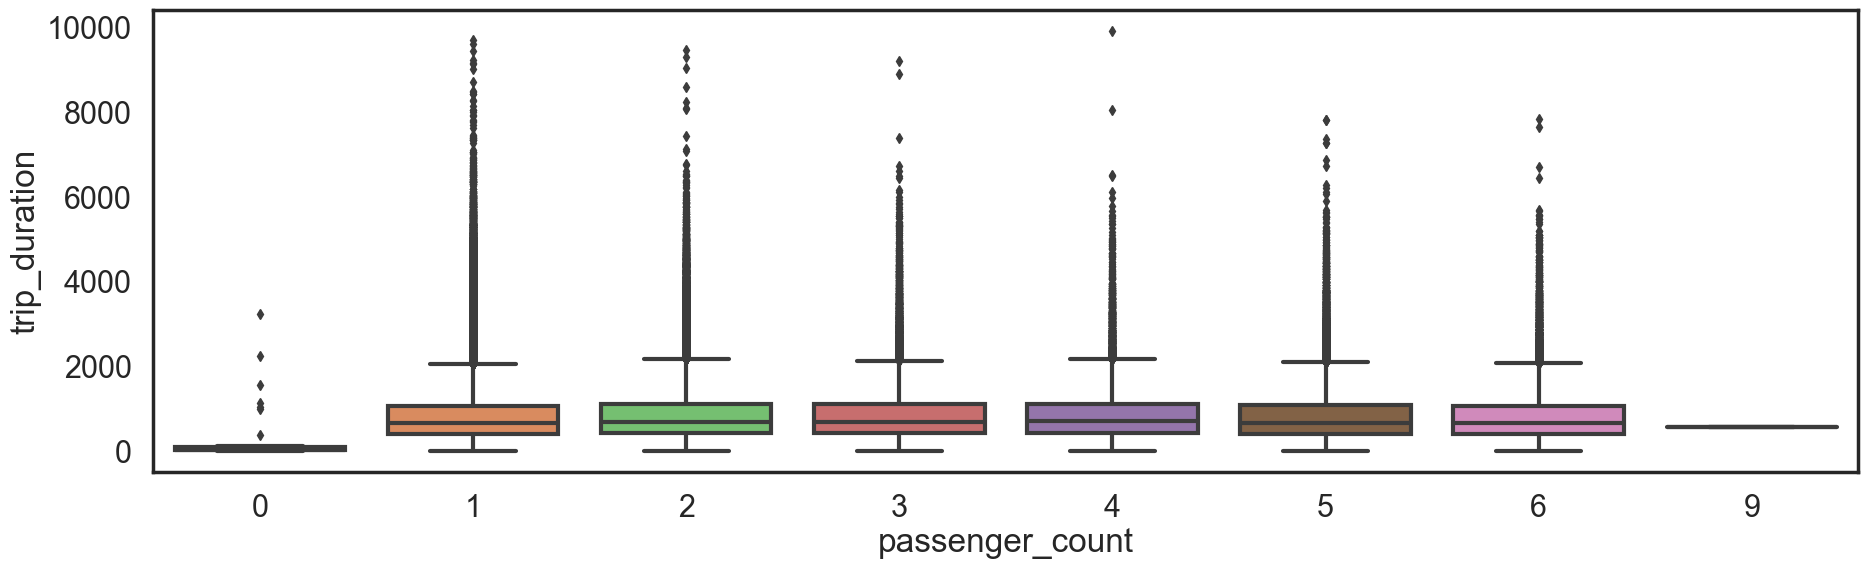

In [29]:
df.passenger_count.value_counts()
plt.figure(figsize=(22, 6))
df_sub = df[df['trip_duration'] < 10000]
sns.boxplot(x="passenger_count", y="trip_duration", data=df_sub)
plt.show()



* The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
* Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.

### Visualise most frequently occuring Pickup points on the lattitude-longitude Map

Here, we try to visualise the most frequently occuring pickup points on the map and check how it is distributed spatially.

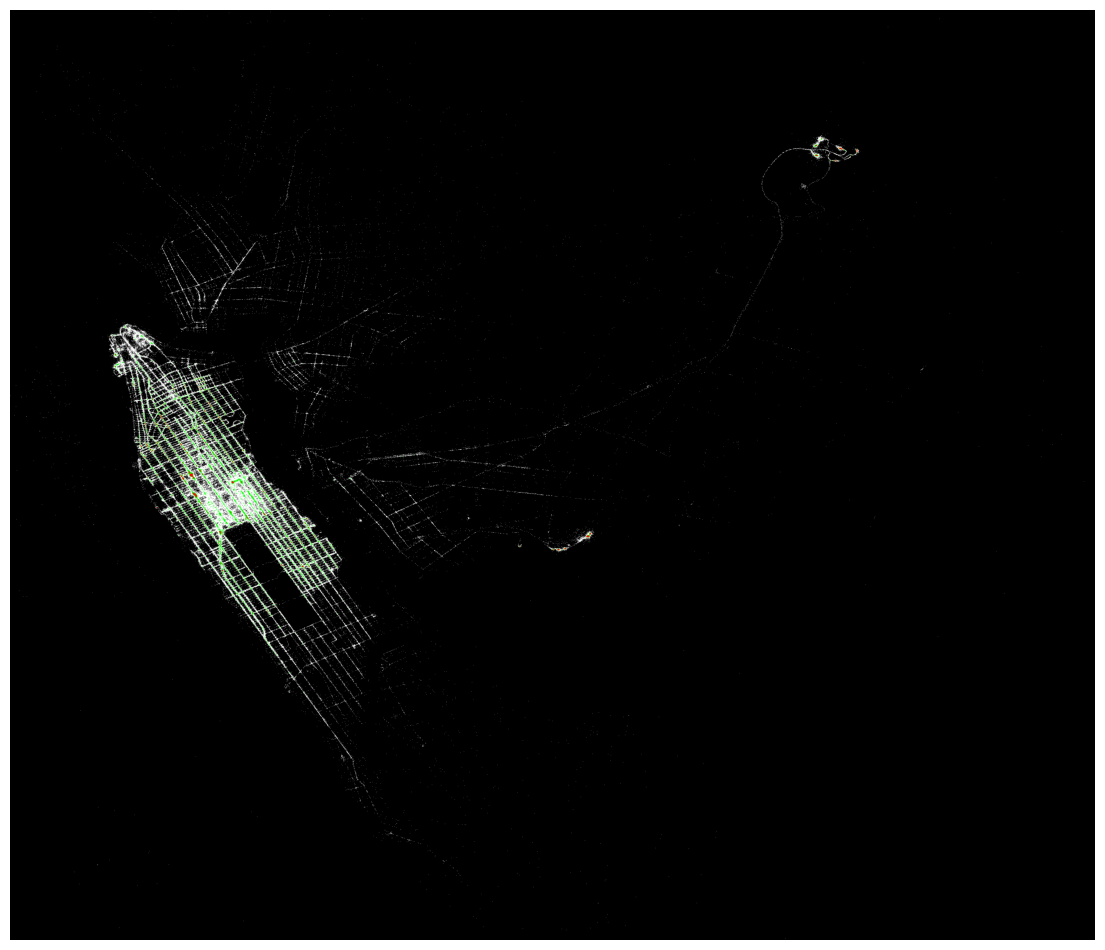

In [30]:

rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

Findings - From the heatmap kind of image above -

* White points - 1-10 trips have white as pickup point
* Green points - 10-25 trips have green as pickup point
* Red points - More than 25 trips have red as pickup point

As expected there are a few small clusters for hot pickup points as displayed by red in the above plot. Most pickup points have less than 10 trips and distributed all over the city.

If you go and have a look at an actual map of New York City, red and green points are mostly concentrated around the Manhatten Area

In [31]:
df.head()
data_new=df.drop(['id', 'pickup_datetime', 'dropoff_datetime','check_trip_duration','log_trip_duration'],
        axis=1)

In [32]:
data_new.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,day_of_week,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
0,2,1,-73.953918,40.778873,-73.963875,40.771164,0,400,1.199074,0,...,0,0,1,0,0,0,0,0,0,0
1,1,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,4.129117,4,...,0,1,0,1,0,0,0,0,0,0
2,2,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.250763,6,...,0,0,0,1,0,0,0,0,0,0
3,2,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,2.361101,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1,-74.017120,40.708469,-73.988182,40.740631,0,848,4.328540,2,...,0,0,1,0,0,0,0,0,0,0


### Correlation Heatmap

Let us quickly look at the correlation heatmap to check the correlations amongst all features.

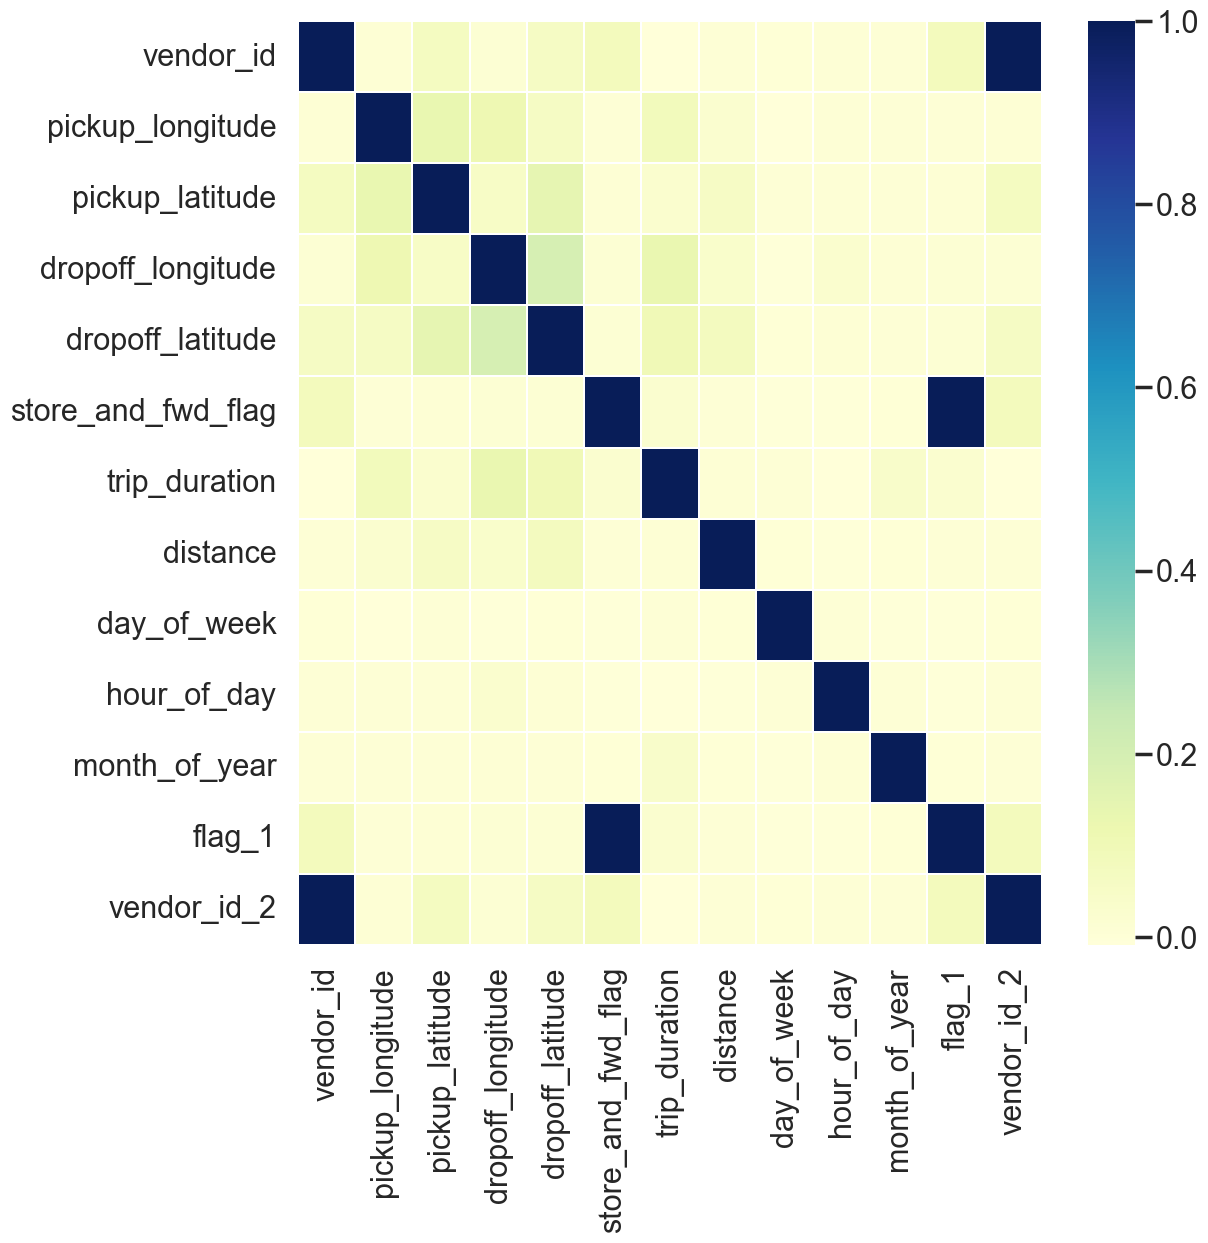

In [33]:
plt.figure(figsize=(12, 12))
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime','month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'weekday_num_1', 'weekday_num_2', 'weekday_num_3',
       'weekday_num_4', 'weekday_num_5', 'weekday_num_6', 'pickup_hour_1',
       'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5',
       'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9',
       'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12', 'pickup_hour_13',
       'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16', 'pickup_hour_17',
       'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20', 'pickup_hour_21',
       'pickup_hour_22', 'pickup_hour_23', 'passenger_count_1',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'passenger_count_7',
       'passenger_count_9','passenger_count','check_trip_duration','log_trip_duration'],
        axis=1)
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 11 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. As discussed earlier, there are a few huge outliers near 12.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.
12. The boxplot clearly shows that there not much of a difference in distribution for the most frequently occuring passenger count values - 1, 2, 3.
13. Another key observation is that the number of outliers are reduced for higher passenger counts but that only comes down to the individual frequencies of each passenger count.
14. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.

In [35]:
df=data_new
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,day_of_week,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
0,2,1,-73.953918,40.778873,-73.963875,40.771164,0,400,1.199074,0,...,0,0,1,0,0,0,0,0,0,0
1,1,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,4.129117,4,...,0,1,0,1,0,0,0,0,0,0
2,2,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.250763,6,...,0,0,0,1,0,0,0,0,0,0
3,2,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,2.361101,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1,-74.017120,40.708469,-73.988182,40.740631,0,848,4.328540,2,...,0,0,1,0,0,0,0,0,0,0


In [36]:
df.shape

(726195, 56)

In [37]:
data=data_new

## Regression Benchmark

### Shuffling and Creating Train and Test Set

In [38]:
# importing shuffle module from sklearn

from sklearn.utils import shuffle

# Shuffling the Dataset
data = shuffle(df, random_state = 40)

#creating 4 divisions
div = int(data.shape[0]/4)

# 3 parts to train set and 1 part to test set
train = data.loc[:3*div+1,:]
test = data.loc[3*div+1:]

In [39]:
train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,day_of_week,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
5341,2,1,-74.008873,40.719044,-73.992554,40.696304,0,1108,2.878464,1,...,0,0,1,0,0,0,0,0,0,0
558117,2,2,-73.966248,40.804699,-73.974777,40.777142,0,552,3.147257,5,...,0,0,0,1,0,0,0,0,0,0
338318,1,1,-73.969460,40.785057,-73.958397,40.784317,0,414,0.935029,4,...,0,0,1,0,0,0,0,0,0,0
720485,1,1,-73.980965,40.759106,-73.975906,40.786545,0,654,3.080684,6,...,0,0,1,0,0,0,0,0,0,0
521477,1,1,-73.972038,40.786400,-73.969765,40.784855,0,1494,0.257201,4,...,0,0,1,0,0,0,0,0,0,0


In [40]:
test.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,day_of_week,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
544645,2,1,-73.979713,40.739605,-73.991188,40.723503,0,441,2.034825,5,...,0,0,1,0,0,0,0,0,0,0
352867,1,1,-74.004494,40.730526,-73.988998,40.722485,0,781,1.582561,3,...,0,0,1,0,0,0,0,0,0,0
367365,1,1,-73.978409,40.754086,-73.967659,40.761921,0,520,1.256539,0,...,0,0,1,0,0,0,0,0,0,0
597041,1,3,-73.979660,40.766167,-74.005363,40.740696,0,817,3.564975,3,...,0,0,0,0,1,0,0,0,0,0
670450,2,1,-73.986328,40.767021,-73.984100,40.740250,0,1175,2.982773,3,...,0,0,1,0,0,0,0,0,0,0


### Simple Mean ( Taxi trip duration mean )

In [41]:
# storing simple mean in a new column in the test set as "simple_mean"

test['simple_mean'] = train['trip_duration'].mean()

In [42]:
#calculating mean absolute error
from sklearn.metrics import mean_absolute_error as MAE

simple_mean_error = MAE(test['trip_duration'] , test['simple_mean'])
simple_mean_error

612.0426938666318

### Mean Taxi trip duration with respect to vendor_id

In [43]:
ven_type = pd.pivot_table(train, values='trip_duration', index = ['vendor_id'], aggfunc=np.mean)
ven_type

,trip_duration
vendor_id,
1,823.758568
2,1052.762894


In [44]:
# initializing new column to zero
test['vendor_id_mean'] = 0

# For every unique entry in Outlet_Identifier
for i in train['vendor_id'].unique():
  # Assign the mean value corresponding to unique entry
  test['vendor_id_mean'][test['vendor_id'] == str(i)] = train['trip_duration'][train['vendor_id'] == str(i)].mean()

In [45]:
#calculating mean absolute error
ven_type_error = MAE(test['trip_duration'] , test['vendor_id_mean'] )
ven_type_error

946.5173266529192

### Mean trip duration with respect to day of the week

In [46]:
week_day = pd.pivot_table(train, values='trip_duration', index = ['day_of_week'], aggfunc=np.mean)
week_day

,trip_duration
day_of_week,
0,894.223092
1,929.342203
2,981.720855
3,994.972143
4,990.064223
5,906.287957
6,919.056285


In [47]:
# initializing new column to zero
test['day_of_week_mean'] = 0

# For every unique entry in Outlet_Identifier
for i in train['day_of_week'].unique():
  # Assign the mean value corresponding to unique entry
  test['day_of_week_mean'][test['day_of_week'] == i] = train['trip_duration'][train['day_of_week'] == i].mean()

In [48]:
#calculating mean absolute error
day_week_error = MAE(test['trip_duration'] , test['day_of_week_mean'] )
day_week_error

610.9786581188705

### Mean trip duration with respect to hour of day

In [49]:
day_hour = pd.pivot_table(train, values='trip_duration', index = ['hour_of_day'], aggfunc=np.mean)
day_hour

,trip_duration
hour_of_day,
0,873.844137
1,897.451921
2,898.528616
3,1030.343896
4,943.544505
5,910.214837
6,676.420507
7,782.409932
8,950.844095


In [50]:
# initializing new column to zero
test['hour_of_day_mean'] = 0

# For every unique entry in Outlet_Identifier
for i in train['hour_of_day'].unique():
  # Assign the mean value corresponding to unique entry
  test['hour_of_day_mean'][test['hour_of_day'] == i] = train['trip_duration'][train['hour_of_day'] == i].mean()

In [51]:
#calculating mean absolute error
hour_day_error = MAE(test['trip_duration'] , test['hour_of_day_mean'] )
hour_day_error

610.3031162620629

### Mean trip duration with respected to vendor id and day of week

In [52]:
combo = pd.pivot_table(train, values = 'trip_duration', index = ['vendor_id','day_of_week'], aggfunc = np.mean)
combo

trip_duration
vendor_id day_of_week               
1         0               792.276114
          1               845.046274
          2               871.167126
          3               877.846308
          4               855.252762
          5               768.444541
          6               745.772653
2         0               982.354824
          1              1002.417352
          2              1079.843419
          3              1096.219310
          4              1105.494074
          5              1025.418531
          6              1066.099049

In [53]:
# Initiating new empty column
test['Super_mean'] = 0

# Assigning variables to strings ( to shorten code length)
s2 = 'vendor_id'
s1 = 'day_of_week'

# For every Unique Value in s1
for i in test[s1].unique():
  # For every Unique Value in s2
  for j in test[s2].unique():
    # Calculate and Assign mean to new column, corresponding to both unique values of s1 and s2 simultaneously
    test['Super_mean'][(test[s1] == i) & (test[s2]==str(j))] = train['trip_duration'][(train[s1] == i) & (train[s2]==str(j))].mean()

In [54]:
#calculating mean absolute error
super_mean_error = MAE(test['trip_duration'] , test['Super_mean'] )
super_mean_error

946.5173266529192

## KNN Regression

In [55]:
df.head()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,day_of_week,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
0,2,1,-73.953918,40.778873,-73.963875,40.771164,0,400,1.199074,0,...,0,0,1,0,0,0,0,0,0,0
1,1,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,4.129117,4,...,0,1,0,1,0,0,0,0,0,0
2,2,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.250763,6,...,0,0,0,1,0,0,0,0,0,0
3,2,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,2.361101,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1,-74.017120,40.708469,-73.988182,40.740631,0,848,4.328540,2,...,0,0,1,0,0,0,0,0,0,0


### Segregating variables: Independent and Dependent Variables

In [56]:
data=df

In [57]:
data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,day_of_week,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
0,2,1,-73.953918,40.778873,-73.963875,40.771164,0,400,1.199074,0,...,0,0,1,0,0,0,0,0,0,0
1,1,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,4.129117,4,...,0,1,0,1,0,0,0,0,0,0
2,2,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,7.250763,6,...,0,0,0,1,0,0,0,0,0,0
3,2,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,2.361101,1,...,0,0,0,0,0,0,0,1,0,0
4,1,1,-74.017120,40.708469,-73.988182,40.740631,0,848,4.328540,2,...,0,0,1,0,0,0,0,0,0,0


In [58]:
data.shape

(726195, 56)

In [59]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((726195, 55), (726195,))

### Scaling the data (Using MinMax Scaler)

In [60]:
# Importing MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [61]:
x = pd.DataFrame(x_scaled)

In [62]:
# Importing Train test split
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 56)

### Implementing KNN Regressor

In [63]:
#importing KNN regressor and metric mse

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error as mse

In [64]:
# Creating instance of KNN
reg = KNN(n_neighbors = 50)

# Fitting the model
reg.fit(train_x, train_y)

# Predicting over the Train Set and calculating MSE
test_predict = reg.predict(test_x)
k = mse(test_predict, test_y)
print('Test MSE    ', k )

Test MSE     9863948.617284767


### Elbow for Classifier

In [65]:
def Elbow(K):
  #initiating empty list
    test_mse = []
  
  #training model for evey value of K
    for i in K:
        #Instance of KNN
        reg = KNN(n_neighbors = i)
        reg.fit(train_x, train_y)
        #Appending mse value to empty list claculated using the predictions
        tmp = reg.predict(test_x)
        tmp = mse(tmp,test_y)
        test_mse.append(tmp)
    
    return test_mse

In [66]:
#Defining K range
k = range(1,60)

In [68]:
# calling above defined function
test = Elbow(k)

Text(0.5, 1.0, 'Elbow Curve for test')

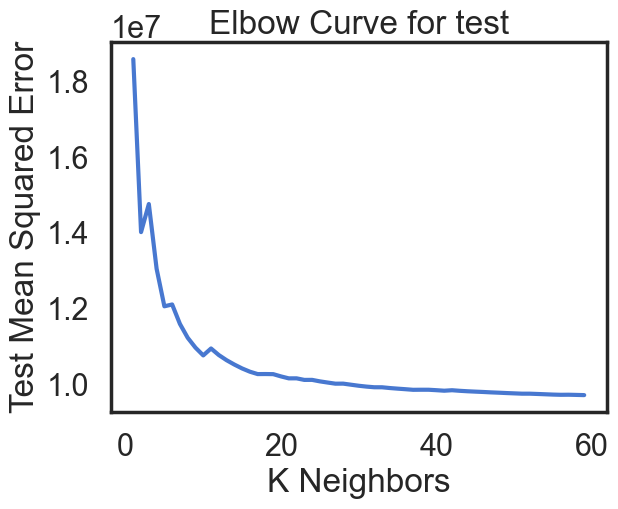

In [69]:
# plotting the Curves
plt.plot(k, test)
plt.xlabel('K Neighbors')
plt.ylabel('Test Mean Squared Error')
plt.title('Elbow Curve for test')

Here we have multiple elbow points, which is not good in case of large dataset. In this case we will select the value which have least Mean square error.

In [82]:
# Creating instance of KNN
reg = KNN(n_neighbors = 10)

# Fitting the model
reg.fit(train_x, train_y)

# Predicting over the Train Set and calculating F1
test_predict = reg.predict(test_x)
k = mse(test_predict, test_y)
print('Test MSE    ', k )

Test MSE     10768326.796031097


## Linear Regression

### Segregating variables: Independent and Dependent Variables

In [65]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((726195, 55), (726195,))

In [66]:
# Importing MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled)

### Splitting the data into train set and the test set

In [67]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(x,y, random_state = 52)

### Implementing Linear Regression

In [68]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

In [69]:
# Creating instance of Linear Regresssion
lr = LR()

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression()

In [70]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 418.8701255396778


In [71]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     424.85489424630424


### Parameters of Linear Regression

In [72]:
lr.coef_

array([ 3.21775856e+12, -7.23921132e+12, -3.16393677e+02,  9.36444702e+01,
       -5.07682877e+02, -3.54337875e+02, -3.40724811e+13,  5.00067804e+03,
        9.46624863e+13,  5.44860792e+13,  3.00072261e+13,  3.40724811e+13,
       -3.21775856e+12, -6.00144523e+12, -1.20028905e+13, -1.80043357e+13,
       -2.40057809e+13, -3.00072261e+13, -1.57770811e+13, -3.15541621e+13,
       -4.73312432e+13, -6.31083242e+13, -7.88854053e+13, -9.46624863e+13,
       -2.36895997e+12, -4.73791993e+12, -7.10687990e+12, -9.47583986e+12,
       -1.18447998e+13, -1.42137598e+13, -1.65827198e+13, -1.89516797e+13,
       -2.13206397e+13, -2.36895997e+13, -2.60585596e+13, -2.84275196e+13,
       -3.07964795e+13, -3.31654395e+13, -3.55343995e+13, -3.79033594e+13,
       -4.02723194e+13, -4.26412794e+13, -4.50102393e+13, -4.73791993e+13,
       -4.97481593e+13, -5.21171192e+13, -5.44860792e+13,  8.04356814e+11,
        1.60871363e+12,  2.41307044e+12,  3.21742725e+12,  4.02178407e+12,
        4.82614088e+12,  

### Plotting the coefficients

Text(0.5, 1.0, 'Coefficient plot')

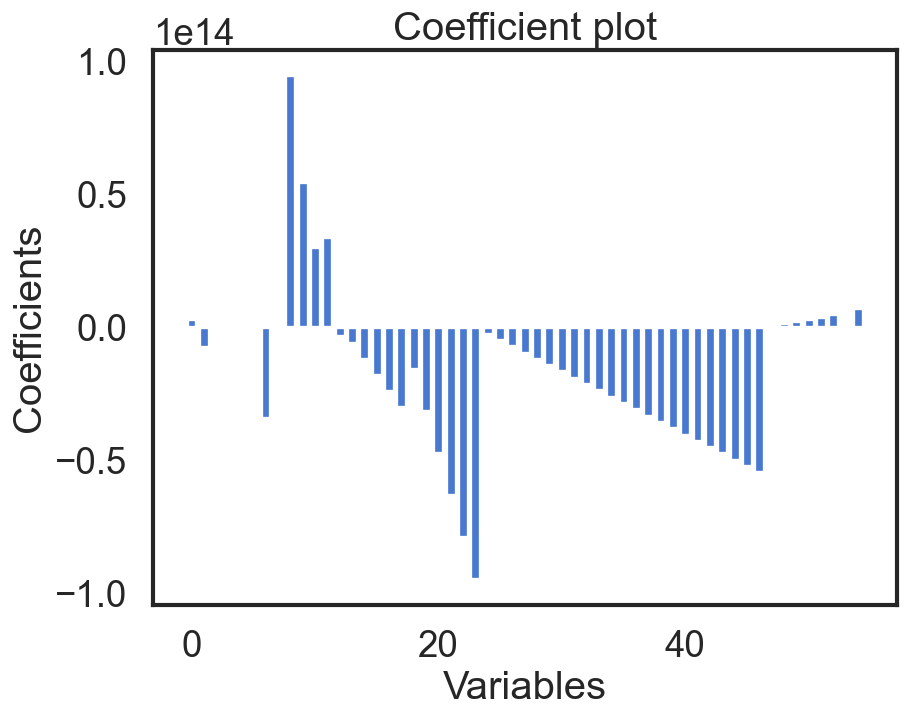

In [73]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

Here we can see that the model depends upon some Independent variables toos much, But these coefficients are not suitable for interpretation because these are not scaled, therefore we will perform the interpretation in this note book later.

### Checking assumptions of Linear Model

In [74]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()

,fitted values,predicted values,residuals
562713,1089,1422.503939,-333.503939
181143,247,927.367220,-680.367220
339009,262,868.441439,-606.441439
259660,1213,1310.839876,-97.839876
206592,714,803.277376,-89.277376


### Checking Distribution of Residuals

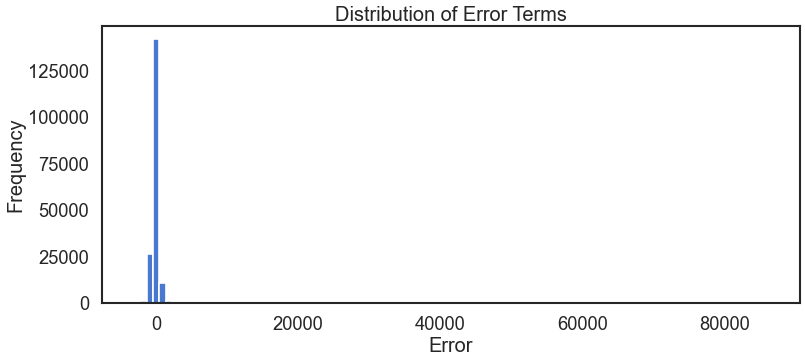

In [79]:
# Histogram for distribution
plt.figure(figsize=(15, 6), dpi=60, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 100)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

### QQ-Plot (Is the data Normally Distributed?)

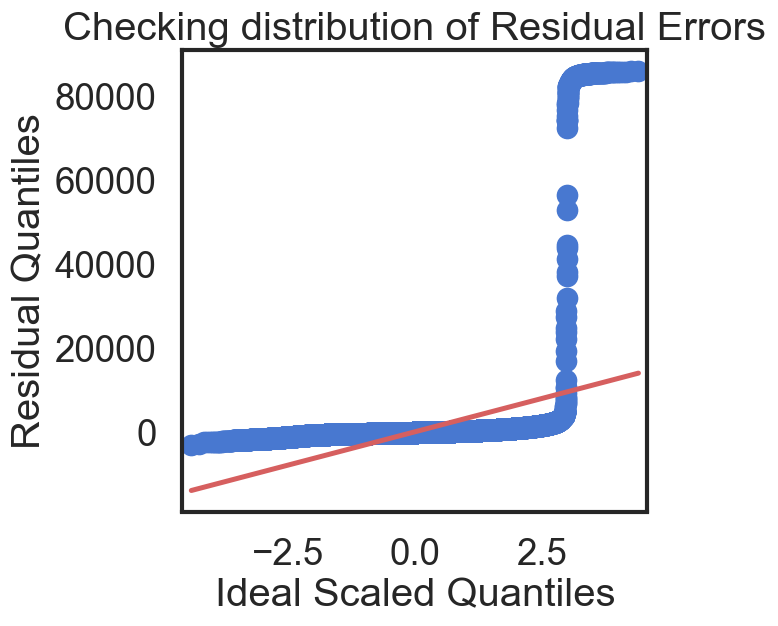

In [76]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()

 The QQ-plot clearly verifies our findings from the the histogram of the residuals, the data is not normal in nature and there sre some outliers on the higher end of the Residues

### Variance Inflation Factor (VIF) (Checking for multi collinearity)

In [77]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Calculating VIF for every column (only works for the not Catagorical)
VIF = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index =data.columns)
VIF

vendor_id                  inf
passenger_count            inf
pickup_longitude      1.431488
pickup_latitude       1.394903
dropoff_longitude     1.312091
dropoff_latitude      1.274595
store_and_fwd_flag         inf
trip_duration         1.021256
distance              1.836872
day_of_week                inf
hour_of_day                inf
month_of_year              inf
flag_1                     inf
vendor_id_2                inf
month_2                    inf
month_3                    inf
month_4                    inf
month_5                    inf
month_6                    inf
weekday_num_1              inf
weekday_num_2              inf
weekday_num_3              inf
weekday_num_4              inf
weekday_num_5              inf
weekday_num_6              inf
pickup_hour_1              inf
pickup_hour_2              inf
pickup_hour_3              inf
pickup_hour_4              inf
pickup_hour_5              inf
pickup_hour_6              inf
pickup_hour_7              inf
pickup_h

From this list, we clearly see that there happens to be no Independent Variable over the value of 5, which means that there are no features that exhibit the Multicollinearity in the dataset.

 ### Model Interpretability

So far we have simply been predicting the values using the linear regression, But in order to Interpret the model, the normalising of the data is essential.

In [80]:
# Creating instance of Linear Regresssion
lr = LR(positive = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(positive=True)

In [81]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 424.491371118455


In [82]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )

Test Mean Absolute Error     430.6831334146591


Text(0.5, 1.0, 'Normalized Coefficient plot')

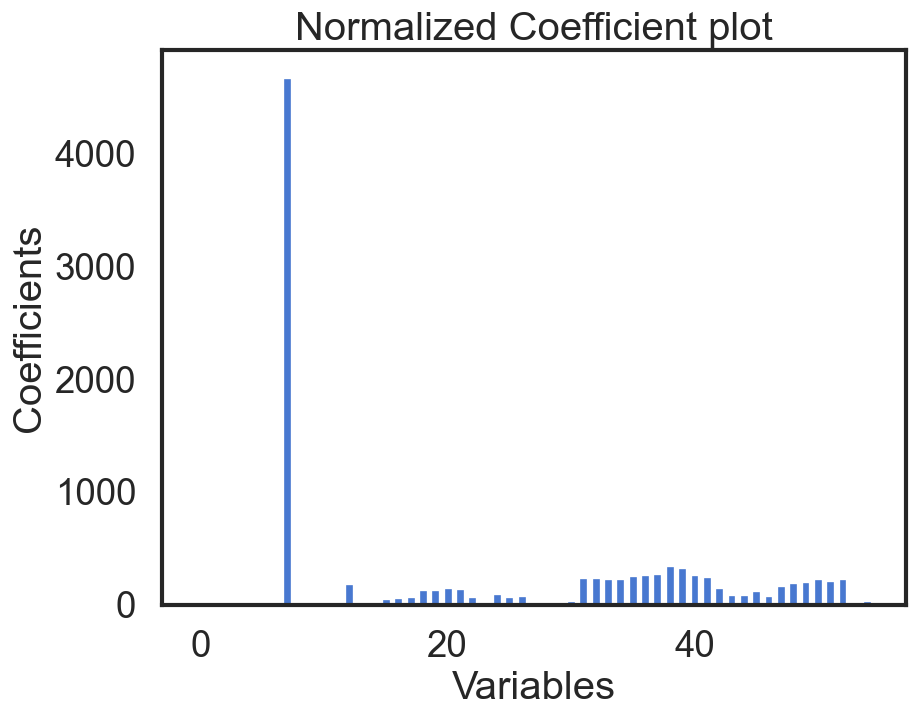

In [83]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

Now the coefficients we see are normalised and we can easily make final inferences out of it.

### Creating new subsets of data

In [84]:
#seperating independent and dependent variables
x = data.drop(['trip_duration'], axis=1)
y = data['trip_duration']
x.shape, y.shape

((726195, 55), (726195,))

### Arranging coefficients with features

In [85]:
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients

,Variable,coefficient
0,vendor_id,0.000000
1,passenger_count,0.000000
2,pickup_longitude,0.000000
3,pickup_latitude,0.000000
4,dropoff_longitude,0.000000
5,dropoff_latitude,0.000000
6,store_and_fwd_flag,6.800596
7,distance,4683.450054
8,day_of_week,0.000000
9,hour_of_day,0.000000


Chossing variables with sigificance greater than 0.5 ( Filtering Significant Features)

In [86]:
sig_var = Coefficients[Coefficients.coefficient > 0.5]

Extracting the significant subset do independent Variables

In [87]:
subset = data[sig_var['Variable'].values]
subset.head()

,store_and_fwd_flag,distance,vendor_id_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,...,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_9
0,0,1.199074,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,4.129117,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,7.250763,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,2.361101,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,4.328540,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


 #### Splitting the data into train set and the test set

In [88]:
# Importing the train test split function
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(subset, y , random_state = 56)

#### Implementing Linear Regression

In [179]:
#importing Linear Regression and metric mean square error
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae

#### Training Mode

In [180]:
# Creating instance of Linear Regresssion with Normalised Data
lr = LR(positive = True)

# Fitting the model
lr.fit(train_x, train_y)

LinearRegression(positive=True)

#### Predicting over the train set

In [181]:
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mae(train_predict, train_y)
print('Training Mean Absolute Error', k )

Training Mean Absolute Error 427.077911264836


#### Predicting over the test set

In [182]:
# Predicting over the Test Set and calculating error
test_predict = lr.predict(test_x)
k = mae(test_predict, test_y)
print('Test Mean Absolute Error    ', k )
print ("R2_Score : ", r2_score(test_predict, y_test))


Test Mean Absolute Error     435.6075950896863
R2_Score :  -32.471902631600145


In [174]:
# coefficeint and intercept
lr.intercept_,lr.coef_


(-166.0921000957453,
 array([  7.58269952, 143.51778493, 193.25354355,   3.21839079,
         59.03349215,  67.59374335,  64.25847174, 153.84182678,
        141.25306748, 156.85062753, 157.42278908,  95.21231028,
         84.43834953, 103.64255122,  68.62251665,  56.81306357,
        234.00015901, 247.94389001, 249.87175177, 250.89225939,
        262.25842053, 272.248565  , 317.89528967, 360.0895978 ,
        338.49361927, 295.17994704, 276.62632835, 166.53902073,
         96.02601526, 119.25804815, 141.09021274,  93.59837288,
        183.39159803, 203.42047632, 247.83517687, 203.88939849,
        235.2739346 , 220.20134491,  77.15713673]))

#### Plotting the coefficients

Text(0.5, 1.0, 'Normalized Coefficient plot')

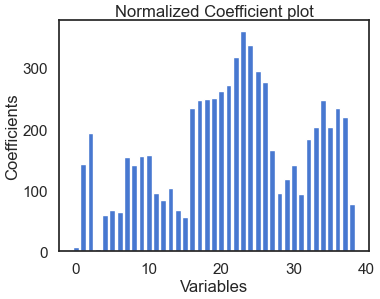

In [93]:
plt.figure(figsize=(8, 6), dpi=50, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

Text(0.5, 1.0, 'Bar plot of Mean absolute error')

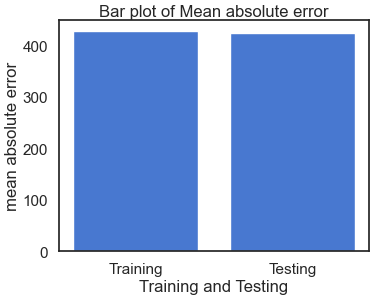

In [94]:
plt.figure(figsize=(8, 6), dpi=50, facecolor='w', edgecolor='b')
x=['Training' , 'Testing']
y=[mae(train_predict, train_y),mae(test_predict, test_y)]
plt.bar( x,y)
plt.xlabel( "Training and Testing")
plt.ylabel('mean absolute error')
plt.title('Bar plot of Mean absolute error')

## Ridge Regression 

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler


In [156]:
#seperating independent and dependent variables
X = data4.drop(['trip_duration'], axis=1)
y = data4['trip_duration']
X.shape, y.shape

((726195, 55), (726195,))

In [157]:
#spliting the data into 4 parts
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=6)

In [158]:
# scaling the splitted data
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)

X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [160]:
#Set the different values of alpha to be tested
alpha_ridge ={"0":0,"10^-8":1e-8,"10^-7":1e-7,"10^-6":1e-6,"10^-5":1e-5,"10^-4":1e-4,"0.001":1e-3,"0.01":1e-2, "1":1, "5":5, "10":10,"20":20,"25":25}

# defining a function which will fit ridge regression model, plot the results, and return the coefficients
def ridge_regression(train_x, train_y, test_x, test_y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(train_x,train_y)
    train_y_pred = ridgereg.predict(train_x)
    test_y_pred = ridgereg.predict(test_x)
    
    return([mae(train_y, train_y_pred), mae(test_y, test_y_pred)])


df_ridge=pd.DataFrame(columns=["Alpha","Train","Test"])
print("Errors are as follows-")
for a,b in alpha_ridge.items():
    rid=ridge_regression(X_train,y_train, X_test, y_test, b)
    df_ridge=df_ridge.append({"Alpha":a,"Train":rid[0],"Test":rid[1]},ignore_index=True)
    
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:.7g}'.format
df_ridge

Errors are as follows-


,Alpha,Train,Test
0,0,422.9655,418.3091
1,10^-8,423.1159,418.4595
2,10^-7,423.1159,418.4595
3,10^-6,423.1159,418.4595
4,10^-5,423.1159,418.4595
5,10^-4,423.1159,418.4595
6,0.001,423.1159,418.4595
7,0.01,423.116,418.4595
8,1,423.1224,418.4659
9,5,423.1468,418.491


In [161]:
# defining a function which will fit ridge regression model, plot the results, and return the coefficients
rid=ridge_regression(X_train,y_train, X_test, y_test, 10**(-2))
rid

[423.1159722369431, 418.4595457016856]

In [169]:
ridgereg = Ridge(alpha=0.01)
ridgereg.fit(train_x,train_y)
train_y_pred = ridgereg.predict(train_x)
test_y_pred = ridgereg.predict(test_x)

#coeficients & intercept
ridgereg.intercept_, ridgereg.coef_

(-155023.2416156829,
 array([  103.29729548,    35.93356588, -1184.71820546,   815.17668034,
        -1233.74035928, -1404.8294249 ,     9.44838223,   149.85329374,
           14.58838823,     8.3931291 ,    14.33053893,     9.44838223,
          103.2972959 ,   -25.92376268,   -23.67073636,    19.10302811,
           11.7964825 ,    -3.37984878,    78.20089351,    84.98276068,
           91.37272669,    63.70286111,   -24.22679683,  -106.89562288,
           41.2256185 ,    37.48421425,     7.28164518,  -120.40610681,
         -290.50585102,  -256.06312079,   -58.82891024,   114.07439763,
          109.01430819,   103.02181198,   107.26666877,   111.56287442,
          113.39798781,   165.4754704 ,   195.05277992,   144.57009136,
          101.90710341,    69.35394658,   -59.27856483,  -161.18665197,
         -131.62609973,  -100.75128285,  -189.99018358,    77.24292463,
           65.13876168,    54.199768  ,    34.62985472,   -15.21023043,
          -66.10908187,     0.        ,    

Text(0.5, 1.0, 'Bar plot of Mean squared error')

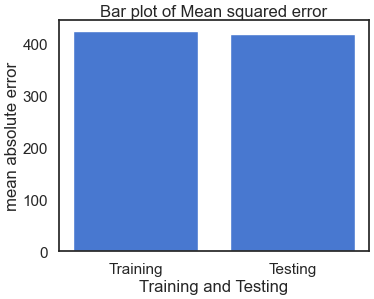

In [168]:
plt.figure(figsize=(8, 6), dpi=50, facecolor='w', edgecolor='b')
x=['Training' , 'Testing']
y=rid
plt.bar( x,y)
plt.xlabel( "Training and Testing")
plt.ylabel('mean absolute error')
plt.title('Bar plot of Mean squared error')

## Lasso Regression

In [163]:
#Set the different values of alpha to be tested
alpha_lasso = {"0.001":1e-3,"0.01":1e-2, "1":1, "5":5, "10":10,"20": 20,"25":25}

# defining a function which will fit lasso regression model, plot the results, and return the coefficients
def lasso_regression(train_x, train_y, test_x, test_y, alpha):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,positive=True)
    lassoreg.fit(train_x,train_y)
    train_y_pred = lassoreg.predict(train_x)
    test_y_pred = lassoreg.predict(test_x)
    
    return([mae(train_y, train_y_pred), mae(test_y, test_y_pred)])


df_lasso=pd.DataFrame(columns=["Alpha","Train","Test"])
print("Errors are as follows-")
for a,b in alpha_lasso.items():
    las=lasso_regression(X_train,y_train, X_test, y_test, b)
    df_lasso=df_lasso.append({"Alpha":a,"Train":las[0],"Test":las[1]},ignore_index=True)

df_lasso

Errors are as follows-


,Alpha,Train,Test
0,0.001,428.5937,423.9422
1,0.01,428.6015,423.9495
2,1,430.5141,425.8979
3,5,444.0839,439.6446
4,10,451.0339,446.6846
5,20,464.9276,460.8081
6,25,474.7129,470.6316


In [164]:
# defining a function which will fit Lasso regression model, plot the results, and return the coefficients
las=lasso_regression(X_train,y_train, X_test, y_test, 0.01)
las

[428.6014612833674, 423.94949035710397]

In [171]:
Lassoreg = Lasso(alpha=0.01)
Lassoreg.fit(train_x,train_y)
#coeficients & intercept
Lassoreg.intercept_, Lassoreg.coef_

(-153201.87311822895,
 array([ 2.04097305e+02,  9.17566011e+00, -1.17728505e+03,  7.90170256e+02,
        -1.22182541e+03, -1.38890541e+03,  1.68610811e+01,  1.49728874e+02,
         9.72148573e+00,  7.34070305e+00,  1.36732078e+01,  1.23519999e-01,
         2.40861196e+00, -2.51600423e+01, -2.22427542e+01,  2.10678980e+01,
         1.44089286e+01, -0.00000000e+00,  8.28131545e+01,  9.44667318e+01,
         1.05715671e+02,  8.29219446e+01, -0.00000000e+00, -7.77692103e+01,
         4.08563804e+01,  3.80546941e+01,  8.70165669e+00, -1.16303111e+02,
        -2.85300863e+02, -2.50256645e+02, -5.21161536e+01,  1.21398713e+02,
         1.17408593e+02,  1.12445750e+02,  1.17729677e+02,  1.23078426e+02,
         1.25956184e+02,  1.79070527e+02,  2.09682666e+02,  1.60213112e+02,
         1.18665137e+02,  8.72188499e+01, -4.00408174e+01, -1.40893799e+02,
        -1.10281214e+02, -7.83373479e+01, -1.66531291e+02, -1.46056421e+01,
         0.00000000e+00,  1.56269921e+01,  2.25482663e+01,  0.0000

Text(0.5, 1.0, 'Bar plot of Mean squared error')

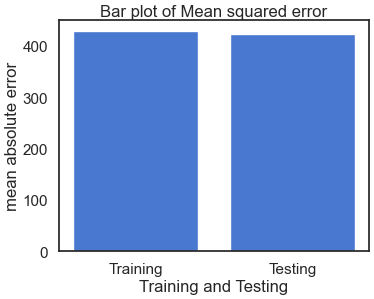

In [167]:
plt.figure(figsize=(8, 6), dpi=50, facecolor='w', edgecolor='b')
x=['Training' , 'Testing']
y=las
plt.bar( x,y)
plt.xlabel( "Training and Testing")
plt.ylabel('mean absolute error')
plt.title('Bar plot of Mean squared error')

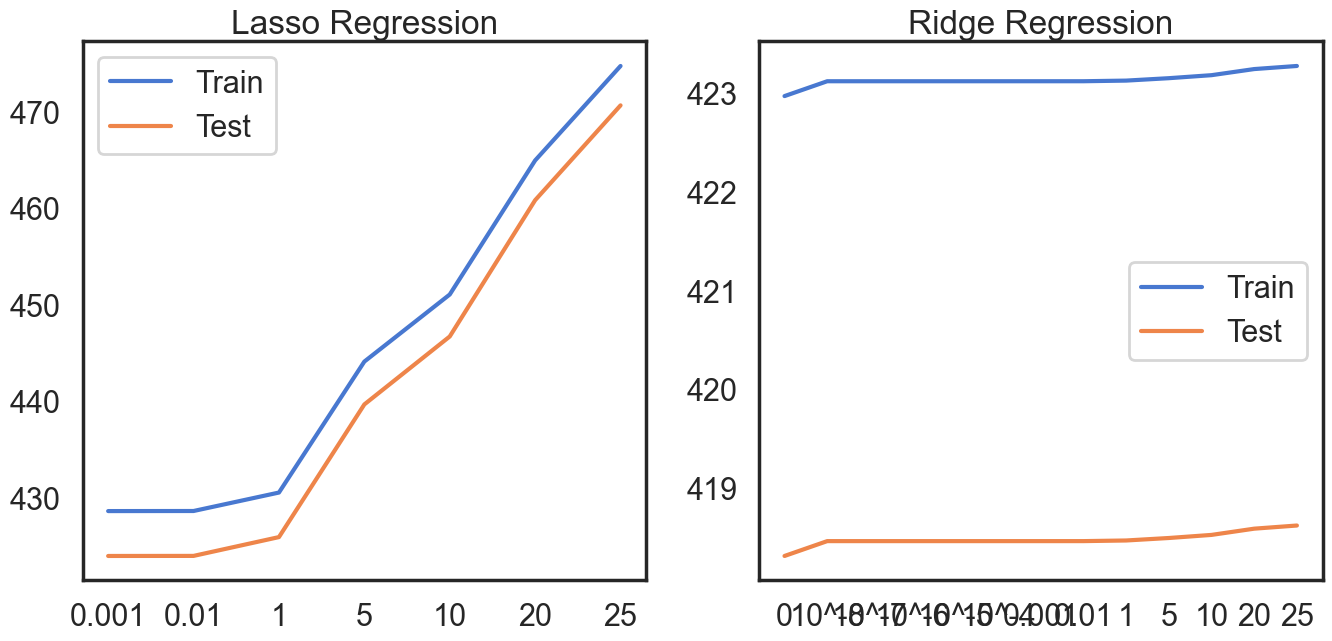

In [166]:


figure,axes= plt.subplots(nrows=1, ncols=2,figsize=(16,7))

axes[0].set_title("Lasso Regression")
axes[1].set_title("Ridge Regression")

axes[0].plot(df_lasso["Alpha"],df_lasso["Train"],label="Train")
axes[0].plot(df_lasso["Alpha"],df_lasso["Test"],label="Test")
axes[0].legend()

axes[1].plot(df_ridge["Alpha"],df_ridge["Train"],label="Train")
axes[1].plot(df_ridge["Alpha"],df_ridge["Test"],label="Test")
axes[1].legend()

plt.show()



## Decision Tree

In [118]:
#Predictors and Target Variable

X = data5.drop(['trip_duration'], axis=1)
y = np.log(data5['trip_duration'])

In [119]:
# Normalising Predictors and creating new dataframe

from sklearn.preprocessing import StandardScaler

cols = X.columns

ss = StandardScaler()

new_df = ss.fit_transform(X)
new_df = pd.DataFrame(new_df, columns=cols)
new_df.head()



,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,day_of_week,hour_of_day,...,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_9
0,0.931462,-0.504406,0.519855,1.001622,0.274095,0.612174,-0.074506,-0.575535,-1.560003,0.372321,...,-0.241904,-0.224753,0.639861,-0.410161,-0.205995,-0.140062,-0.237504,-0.185014,0.0,-0.001173
1,-1.073581,0.257332,-0.391187,-0.691112,-0.644518,-1.815824,-0.074506,0.199395,0.486637,1.465808,...,-0.241904,4.449332,-1.562839,2.438070,-0.205995,-0.140062,-0.237504,-0.185014,0.0,-0.001173
2,0.931462,0.257332,-0.629658,-1.060485,0.745545,0.731727,-0.074506,1.025000,1.509957,0.528533,...,-0.241904,-0.224753,-1.562839,2.438070,-0.205995,-0.140062,-0.237504,-0.185014,0.0,-0.001173
3,0.931462,3.304284,0.314527,0.313705,0.485192,0.913609,-0.074506,-0.268205,-1.048343,-0.721166,...,-0.241904,-0.224753,-1.562839,-0.410161,-0.205995,-0.140062,-0.237504,5.405003,0.0,-0.001173
4,-1.073581,-0.504406,-1.154295,-1.526998,-0.449083,-0.360289,-0.074506,0.252138,-0.536683,-1.189804,...,-0.241904,-0.224753,0.639861,-0.410161,-0.205995,-0.140062,-0.237504,-0.185014,0.0,-0.001173


In [120]:
#importing train test split & some important metrics

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error , mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((508336, 55), (217859, 55), (508336,), (217859,))

In [121]:
#implementation of decision tree

from sklearn.tree import DecisionTreeRegressor

est_dt = DecisionTreeRegressor(criterion="squared_error", max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict(X_test)
dt_pred



array([6.29541998, 5.64160867, 6.96390689, ..., 5.65094157, 6.59613485,
       7.27460696])

In [122]:
#examining metrics

print ("Training Score : " , est_dt.score(X_train, y_train))

print ("Validation Score : ", est_dt.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train, cv=5).mean())

print ("R2_Score_testing : ", r2_score(dt_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.6928708651822486
Validation Score :  0.6682235654743938
Cross Validation Score :  0.6695036133817147
R2_Score :  0.5237204147371569
RMSLE :  0.06672812199831248


Text(0.5, 1.0, 'Test VS Prediction')

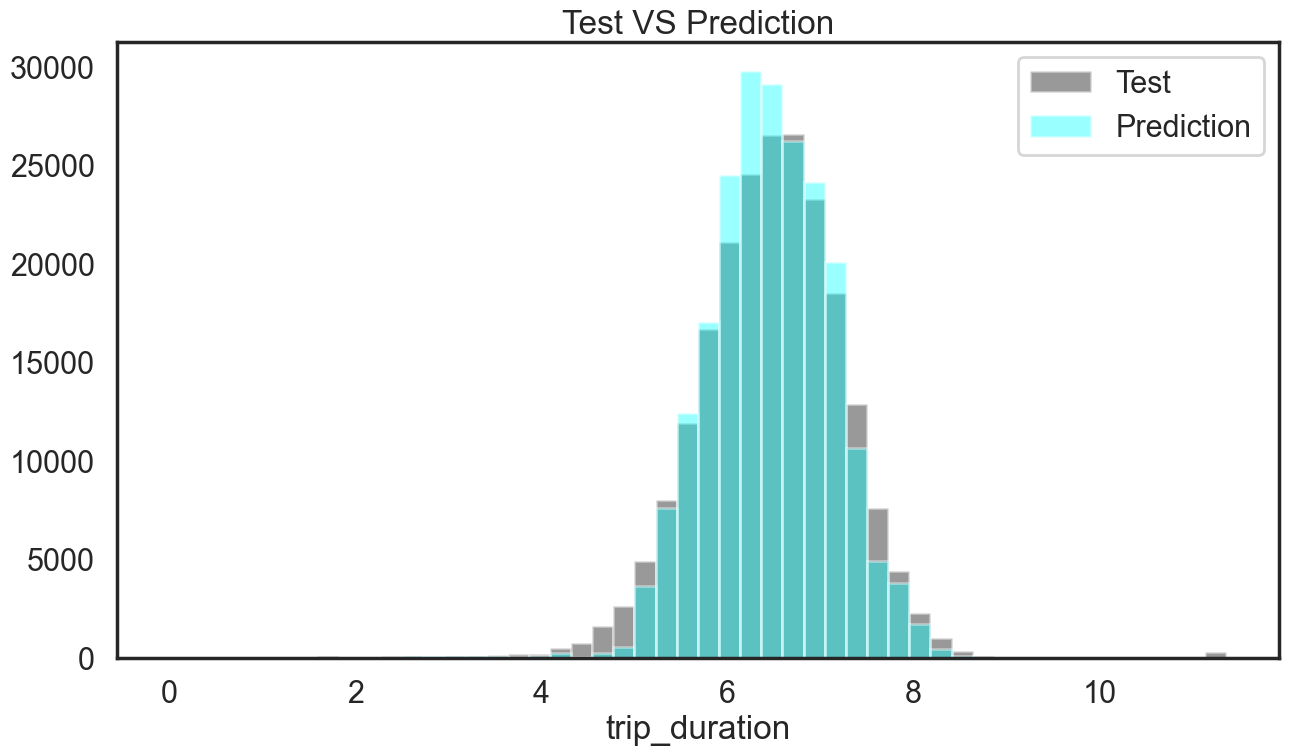

In [123]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(dt_pred, kde=False, color="cyan", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")